In [1]:
import pandas as pd
import numpy as np
import os

In [257]:
os.chdir('/Users/jpmvbastos/Documents/GitHub/ColonialLegacy/')


In [258]:
col = pd.read_excel('Data/colonies_master.xlsx')
efw = pd.read_excel('Data/efotw-2022-master-index-data-for-researchers-iso.xlsx', sheet_name='EFW Panel Data 2022 Report')
vdem = pd.read_excel('Data/VDem.xls')
vdem.rename(columns={'v2x_libdem':'libdem','v2xcl_prpty':'prop_rights','v2clstown':'stateown'}, inplace=True)
hiel = pd.read_excel('Data/HIEL_Countries_1850-2020-1-1.xlsx', sheet_name='HIEL2')

In [259]:
hiel.rename(columns={'U.K.':'Britain'}, inplace=True)
hiel.head()

,year,Australia,New Zealand,Canada,U.S.A.,Japan,Austria,Belgium,Denmark,Finland,...,Greece,Ireland,Italy,Netherlands,Norway,Portugal,Spain,Sweden,Switzerland,Britain
0,1850,7.370177,NaN,7.510861,6.806213,4.606102,6.940374,8.111263,7.970161,NaN,...,6.472487,NaN,NaN,7.992799,7.207302,5.397483,6.114667,7.343413,6.848098,7.631775
1,1851,7.143438,NaN,7.386000,6.799585,3.841691,6.539103,8.058305,8.000717,7.062032,...,6.303446,NaN,NaN,7.840754,7.272691,5.880018,6.232026,7.439410,6.986405,7.733517
2,1852,6.997849,NaN,7.531888,6.867981,4.330228,6.938061,8.015771,8.030629,6.808692,...,5.127223,NaN,NaN,7.657086,7.123638,6.174890,6.368788,7.437745,6.848573,7.704020
3,1853,6.852954,NaN,7.461409,6.867322,3.579719,6.746011,8.011368,8.223173,6.917066,...,5.669832,NaN,NaN,7.726283,7.171848,5.495964,6.172939,7.416812,6.848131,7.582564
4,1854,6.263343,NaN,6.385176,6.632412,5.120513,6.242913,7.276063,8.195692,6.342725,...,6.066569,NaN,NaN,7.678123,6.948659,5.672494,6.232311,7.272991,7.241317,7.482494


In [260]:
#Keep only colonies 
col = col.loc[col['time_total'] > 0]

In [261]:
# Initialize columns with placeholder NaN
for colonizer in col['main'].unique(): 
    col[f'efw_{colonizer.lower()}'] = np.nan
    col[f'timec_{colonizer.lower()}'] = np.nan

In [262]:
# Initialize column
col[['avg_efw', 'timec_total']] = np.nan

for country in col.loc[col['independence'] >= 1850, 'country']:
    for colonizer in col['main'].unique(): 
        begin_year = col.loc[col['country']==country, f'colstart_{colonizer.lower()}'].values[0]
        end_year = col.loc[col['country']==country, f'colend_{colonizer.lower()}'].values[0]
        if begin_year < 1850 and end_year < 1850:
            continue 
        elif begin_year < 1850 and end_year >= 1850:    
            begin_year = 1850
        else:
            pass 
        avg_efw = hiel.loc[(hiel['year'] >= begin_year) & (hiel['year'] <= end_year), colonizer].mean() 
        timec = end_year - begin_year + 1
        col.loc[col['country']==country, f'efw_{colonizer.lower()}'] = avg_efw * timec
        col.loc[col['country']==country, f'timec_{colonizer.lower()}'] = timec

col['timec_total'] = col[['timec_belgium', 'timec_britain', 'timec_france', 'timec_germany', 'timec_italy',
       'timec_netherlands', 'timec_portugal', 'timec_spain']].sum(axis=1) 
col['avg_efw'] = col[['efw_belgium',
       'efw_britain', 'efw_france', 'efw_germany', 'efw_italy',
       'efw_netherlands', 'efw_portugal', 'efw_spain']].sum(axis=1) / col['timec_total']

col['avg_efw'] = col['avg_efw'].replace([np.inf, -np.inf], np.nan)

col = col.drop(columns={'timec_belgium', 'timec_britain', 'timec_france', 'timec_germany',
                         'timec_italy','timec_netherlands', 'timec_portugal', 'timec_spain'})

In [263]:
#Exclude 2020 because of the pandemic
efw = efw.loc[(efw['Year']<2020) & (efw['Year'] >1999)].rename(columns={'World Bank Region': "wb_region"})
efw.sort_values(by=['Countries','Year']).head()

,Year,ISO_Code_2,wb_region,Countries,ISO_Code_3,efw,Area 1,Area 2,Area 3,Area 4,Area 5,std
3300,2000,AL,Europe & Central Asia,Albania,ALB,6.327515,7.553226,4.710276,6.913330,5.701556,6.635993,1.111863
3135,2001,AL,Europe & Central Asia,Albania,ALB,6.472199,7.627792,4.835400,6.799314,5.871650,7.100014,1.103756
2970,2002,AL,Europe & Central Asia,Albania,ALB,6.742276,8.223671,4.845155,7.101343,6.097055,7.291095,1.287959
2805,2003,AL,Europe & Central Asia,Albania,ALB,7.205265,8.204830,5.016305,9.725652,6.107061,6.866163,1.834517
2640,2004,AL,Europe & Central Asia,Albania,ALB,7.128100,7.961247,5.054765,9.558839,6.124404,6.855145,1.730735


In [264]:
means = efw.groupby('ISO_Code_3')[['efw','Area 1','Area 2','Area 3','Area 4','Area 5','std']].mean()
stds = efw.groupby('ISO_Code_3')[['efw','Area 1','Area 2','Area 3','Area 4','Area 5','std']].std()
last = efw.loc[efw['Year']==2019]

In [265]:
df = pd.merge(col, means, left_on='country_code', right_on='ISO_Code_3', how='left')
df = pd.merge(df, stds, left_on='country_code', right_on='ISO_Code_3', how='left', suffixes=('',"_std"))
df = pd.merge(df, last, left_on='country_code', right_on='ISO_Code_3', how='left', suffixes=('',"_2019"))

In [266]:
# Reload because we have dropped years < 2000 for the average above
efw = pd.read_excel('Data/efotw-2022-master-index-data-for-researchers-iso.xlsx', sheet_name='EFW Panel Data 2022 Report')
efw.rename(columns={'ISO_Code_3':'Code'}, inplace=True)
efw_old = pd.read_excel('Data/efotw-2022-master-index-data-for-researchers-iso.xlsx', sheet_name='EFW Data 1950_1965')

In [267]:
# Initiate Columns with nan
df['efw_year'] = np.nan
df['efw_indep'] = np.nan

for country in df['country_code'].sort_values():
    year = df.loc[df['country_code']==country, 'independence'].values[0] #Extracts independence year
    if year < 1940:
        continue 
    elif year > 1965:
        data = efw
    else:
        data = efw_old
    if country not in data['Code'].unique():
        continue 
    else: 
        efw_year = data.loc[(data['Code']==country) & (data['Year']>=year) 
                                        & (data['efw'].notnull()), 'Year'].values.min() #Earliest available year for EFW
        df.loc[df['country_code']==country, 'efw_year'] = efw_year
        efw_indep = data.loc[(data['Code'] == country) & (data['Year'] == efw_year), 'efw'].values[0]
        df.loc[df['country_code']==country, 'efw_indep']  = efw_indep
        print(f'Done: {country}, independence {year}, EFW is {efw_indep} from year {efw_year}.')

Done: AGO, independence 1974, EFW is 4.214590452408931 from year 2005.
Done: ARE, independence 1971, EFW is 6.300634374560825 from year 1975.
Done: BDI, independence 1962, EFW is 4.485272226618234 from year 1965.
Done: BEN, independence 1960, EFW is 3.8121843824880184 from year 1960.
Done: BFA, independence 1960, EFW is 5.327570739242722 from year 1960.
Done: BHR, independence 1971, EFW is 6.556555046352825 from year 1975.
Done: BHS, independence 1973, EFW is 6.85628691546833 from year 1975.
Done: BLZ, independence 1980, EFW is 6.4609229140754785 from year 1980.
Done: BRB, independence 1966, EFW is 5.888608438420466 from year 1975.
Done: BRN, independence 1984, EFW is 7.262705105694444 from year 2010.
Done: BWA, independence 1966, EFW is 5.256834874059234 from year 1975.
Done: CAF, independence 1960, EFW is 4.11366409510029 from year 1960.
Done: CIV, independence 1960, EFW is 4.2507831480984715 from year 1960.
Done: CMR, independence 1961, EFW is 5.917432967630137 from year 1965.
Done:

In [269]:
df.to_excel('Data/colonies.xlsx', index=False)

# Weights Plot

In [166]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

# Reset Matplotlib parameters to default
mpl.rcParams.update(mpl.rcParamsDefault)

# Load world map shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Load dataset containing variable values for each country
# Replace 'your_data.csv' with your dataset file containing country codes/names and variable values
data = pd.read_excel('/Users/jpmvbastos/Documents/GitHub/ColonialLegacy/Data/ColonialEFW.xlsx')

/var/folders/xd/gksdz50d7r3765bw8t_98y880000gn/T/ipykernel_16924/1174419897.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [ ]:
data[['relwt3', 'relwt4']].describe()

,relwt3,relwt4
count,87.000000,107.000000
mean,0.011494,0.009346
std,0.002769,0.003626
min,0.005860,0.000590
25%,0.009942,0.006369
50%,0.012360,0.009993
75%,0.013724,0.012274
max,0.017339,0.015619


In [167]:
merged_data = world.merge(data, how='left', left_on='iso_a3', right_on='country_code')

# Create a dummy = 1 if the variable is missing, 0 otherwise
merged_data['miss3'] = np.where(merged_data['relwt3'].isnull(), 1, 0)
merged_data['miss4'] = np.where(merged_data['relwt4'].isnull(), 1, 0)

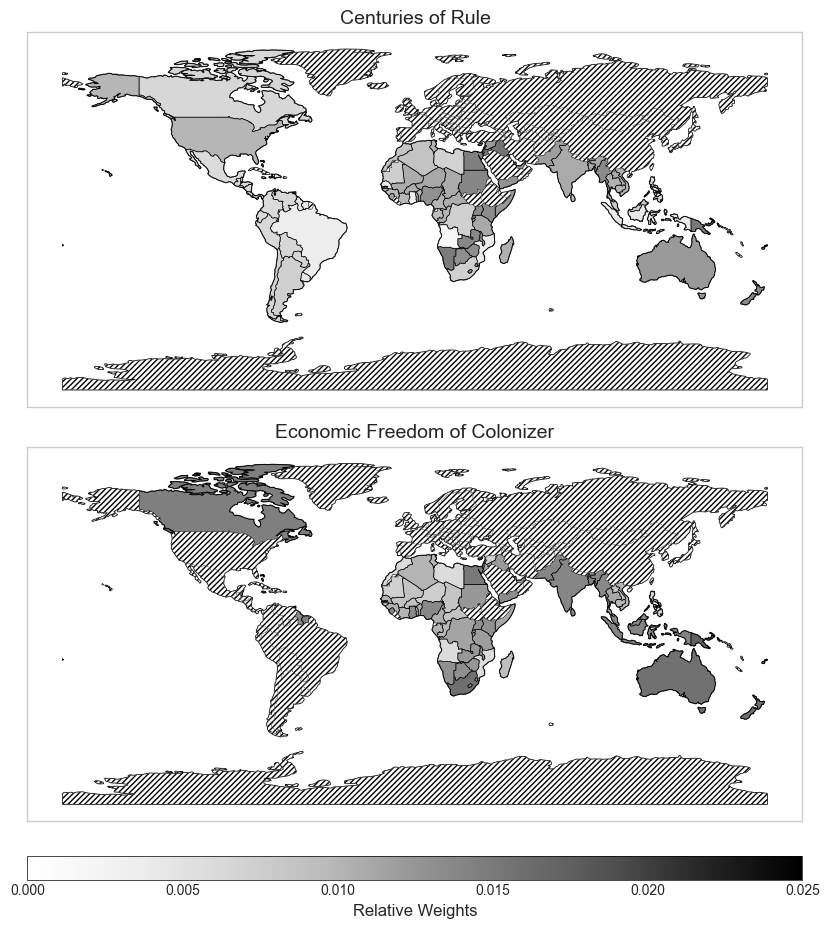

In [235]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create a grid of subplots
fig, (ax1, ax2, cax) = plt.subplots(3, 1, figsize=(10, 12), gridspec_kw={'height_ratios': [1.5, 1.5, 0.01]}) 

# Plot the first map
world.plot(ax=ax1, color='white', edgecolor='black')
merged_data[merged_data['miss3']==0].plot(column='relwt3', cmap='Greys', linewidth=0.5, ax=ax1, edgecolor='black', legend=False, vmin=0, vmax=0.025)
merged_data[merged_data['miss3']==1].plot(ax=ax1, hatch='//////', color='white', linewidth=0.1, edgecolor='black')
ax1.set_title('Economic Freedom of Colonizer', fontsize=14)
ax1.set_xticks([])
ax1.set_yticks([])

# Plot the second map
world.plot(ax=ax2, color='white', edgecolor='black')
merged_data[merged_data['miss4']==0].plot(column='relwt4', cmap='Greys', linewidth=0.5, ax=ax2, edgecolor='black', legend=False, vmin=0, vmax=0.025)
merged_data[merged_data['miss4']==1].plot(ax=ax2, hatch='//////', color='white', linewidth=0.1, edgecolor='black')
ax2.set_title('Centuries of Rule', fontsize=14)
ax2.set_xticks([])
ax2.set_yticks([])

# Add colorbar
divider = make_axes_locatable(cax)
cbar = fig.colorbar(sm2, ax=cax, orientation='horizontal', pad=0.05, cax=cax)
cbar.set_label('Relative Weights', fontsize=12)
cbar.outline.set_edgecolor('black')   # Set edge color of the colorbar
cbar.outline.set_linewidth(.5)         # Set linewidth of the colorbar edge

ax1.set_facecolor('white')
ax2.set_facecolor('white')

# Adjust spacing between ax1 and ax2
#plt.subplots_adjust(hspace=-)  # Adjust the vertical space between subplots

# Adjust the top of ax1 and the bottom of ax2 to reduce space between them
ax1.set_position([ax1.get_position().x0, ax1.get_position().y0, ax1.get_position().width, 0.45])
ax2.set_position([ax2.get_position().x0, 0.9, ax2.get_position().width, 0.45])

# Adjust the position of cax to align with the subplots
cax.set_position([cax.get_position().x0, 0.575, cax.get_position().width, 0.02])

plt.show()

# Export as EPS file
fig.savefig('/Users/jpmvbastos/Documents/GitHub/ColonialLegacy/Results/Relative Weights.png', format='png', dpi=500)

